In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, RobustScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

## Загрузка датасета

In [2]:
credit = pd.read_csv('BankChurners.csv') # https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers/data
credit = credit.drop(columns = credit.columns[-2:])
credit.columns = credit.columns.str.lower()

In [3]:
credit.isnull().sum() # нулевых значений нет

clientnum                   0
attrition_flag              0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
dtype: int64

In [4]:
credit.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
clientnum,10127.0,739177606.3,36903783.5,708082083.0,713036770.5,717926358.0,773143533.0,828343083.0
customer_age,10127.0,46.3,8.0,26.0,41.0,46.0,52.0,73.0
dependent_count,10127.0,2.3,1.3,0.0,1.0,2.0,3.0,5.0
months_on_book,10127.0,35.9,8.0,13.0,31.0,36.0,40.0,56.0
total_relationship_count,10127.0,3.8,1.6,1.0,3.0,4.0,5.0,6.0
months_inactive_12_mon,10127.0,2.3,1.0,0.0,2.0,2.0,3.0,6.0
contacts_count_12_mon,10127.0,2.5,1.1,0.0,2.0,2.0,3.0,6.0
credit_limit,10127.0,8632.0,9088.8,1438.3,2555.0,4549.0,11067.5,34516.0
total_revolving_bal,10127.0,1162.8,815.0,0.0,359.0,1276.0,1784.0,2517.0
avg_open_to_buy,10127.0,7469.1,9090.7,3.0,1324.5,3474.0,9859.0,34516.0


In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

In [6]:
credit['income_category'].value_counts()

income_category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64

Text(0.5, 1.0, 'Денежный оборот на кредитной карте, зависящий от пола')

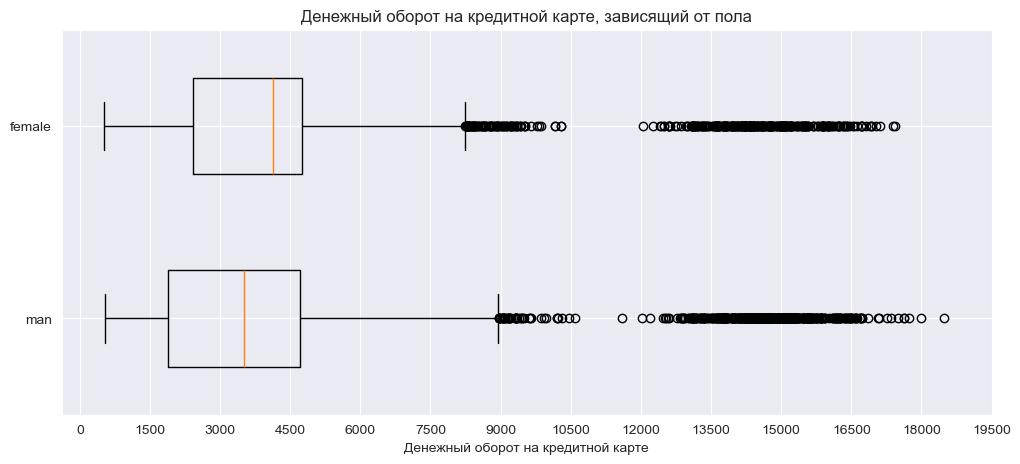

In [9]:
 
task_3_1 = credit[["gender", "total_trans_amt"]]
male = task_3_1.query("gender == 'M'")
female = task_3_1.query("gender == 'F'")

fig, ax = plt.subplots(figsize = (12,5))

ax.boxplot([male["total_trans_amt"], female["total_trans_amt"]], widths = 0.5, tick_labels = ["man", "female"], vert = False)

plt.xlabel('Денежный оборот на кредитной карте')
plt.xticks(np.arange(0, 20000, 1500))
plt.title("Денежный оборот на кредитной карте, зависящий от пола")


In [8]:
print(male['total_trans_amt'].mean())
print(female['total_trans_amt'].mean())

4493.706227720696
4324.318215752146


У девушек медиана смещена в большую сторону в сравнение с мужчинами, но у мужчин больше среднее.

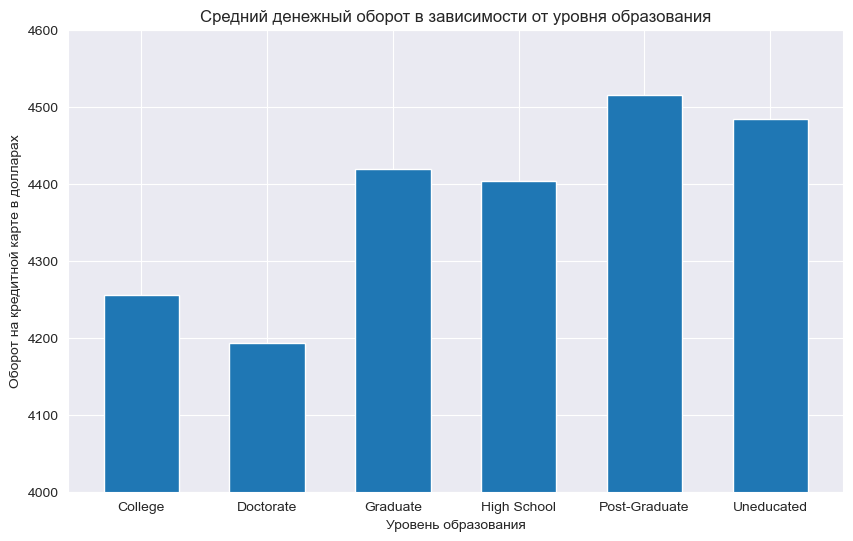

In [10]:
task_3_2 = credit[["education_level", "total_trans_amt"]]
task_3_2 = task_3_2.groupby(["education_level"], as_index = False).mean().drop(6)

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(task_3_2['education_level'], height = task_3_2["total_trans_amt"], width = 0.6 )
ax.set_ylim(4000, 4600)

plt.xlabel('Уровень образования')
plt.ylabel('Оборот на кредитной карте в долларах')
plt.title('Средний денежный оборот в зависимости от уровня образования')
plt.grid(axis='y', linestyle='-', alpha=1) 

А говорят без образования никуда)

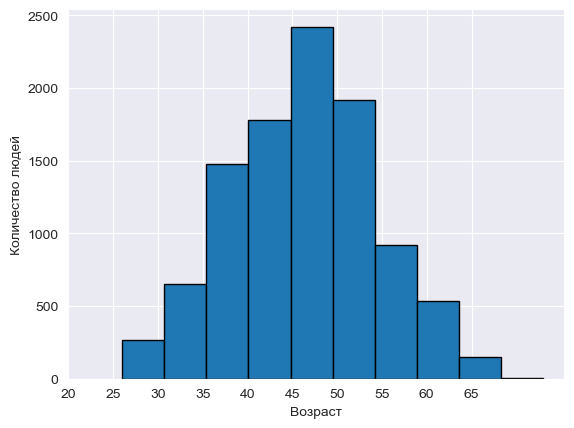

In [11]:
task_3_3 = credit['customer_age']
plt.hist(task_3_3, edgecolor = 'black')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.xticks(np.arange(20, 70, 5))  

plt.show()

In [12]:
print('Матожидание:', np.mean(task_3_3))
print('Стандартное отклонение:', np.std(task_3_3))
print("Основной возраст людей находится в промежутке от", np.quantile(task_3_3, 0.25), 'до', np.quantile(task_3_3, 0.75), "лет")

Матожидание: 46.32596030413745
Стандартное отклонение: 8.016418208911816
Основной возраст людей находится в промежутке от 41.0 до 52.0 лет


<Axes: >

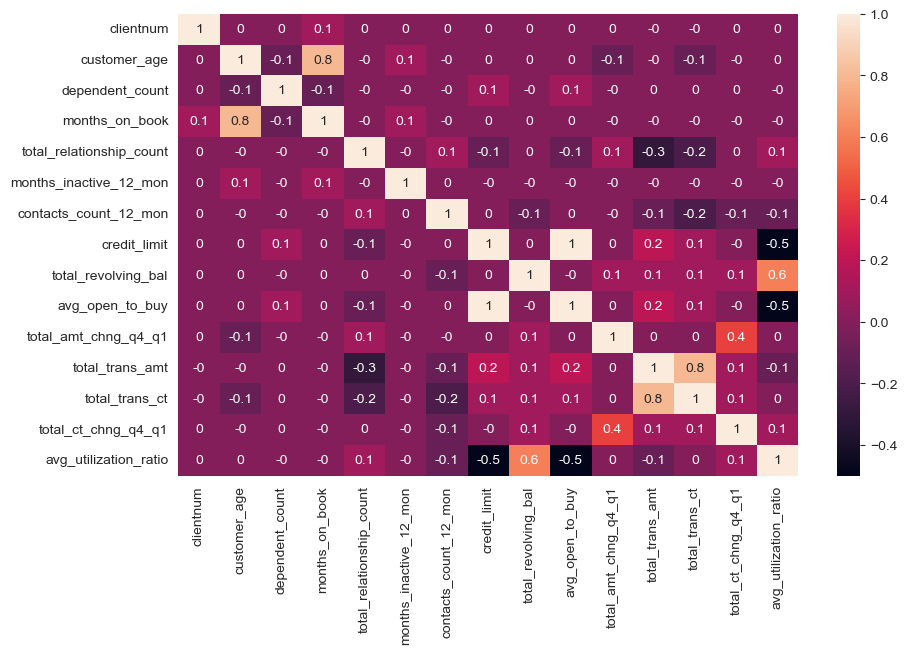

In [13]:
non_object_columns = credit.select_dtypes(exclude=['object'])
fig, ax = plt.subplots(figsize = (10, 6))
# Корреляционная матрица для количественных признаков
sns.heatmap(non_object_columns.corr().round(1), annot = True)

Ну каких-то скрытых зависимостей не обнаружено только, понятно то что от возраста зависит, сколько ты держишь свою кредитную карту. Ну и остальные также нам новую информацию не даёт. Например от количество денег, которые ты тратишь вырастает коэффицициент использования карты. Можно было бы и поработать с категориальными данными, но их посмотрим череp pandas_profilling. 

In [14]:
credit['attrition_flag'].value_counts() # Целевая переменная 

attrition_flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

In [15]:
# PCA можем впринципе выкинуть пару фич
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

credit_copy_2 = credit.copy()

X = credit_copy_2.drop(columns = ['clientnum','attrition_flag']).select_dtypes(exclude = ['object'])
feature_names = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

feature_importances = np.sum(pca.components_**2, axis=0)
#  Нормализуем, чтобы значимость была от 0 до 1
feature_importances /= np.sum(feature_importances)

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)
print("Суммарная объясненная дисперсия:", np.sum(explained_variance_ratio))
importance_df

Explained variance ratio: [0.18343028 0.14608437]
Суммарная объясненная дисперсия: 0.329514649432426


,Feature,Importance
8,avg_open_to_buy,0.166199
10,total_trans_amt,0.161186
11,total_trans_ct,0.156433
6,credit_limit,0.154927
13,avg_utilization_ratio,0.137565
7,total_revolving_bal,0.045625
3,total_relationship_count,0.041336
0,customer_age,0.037766
2,months_on_book,0.036765
12,total_ct_chng_q4_q1,0.022063


# Работа с аномалиями 

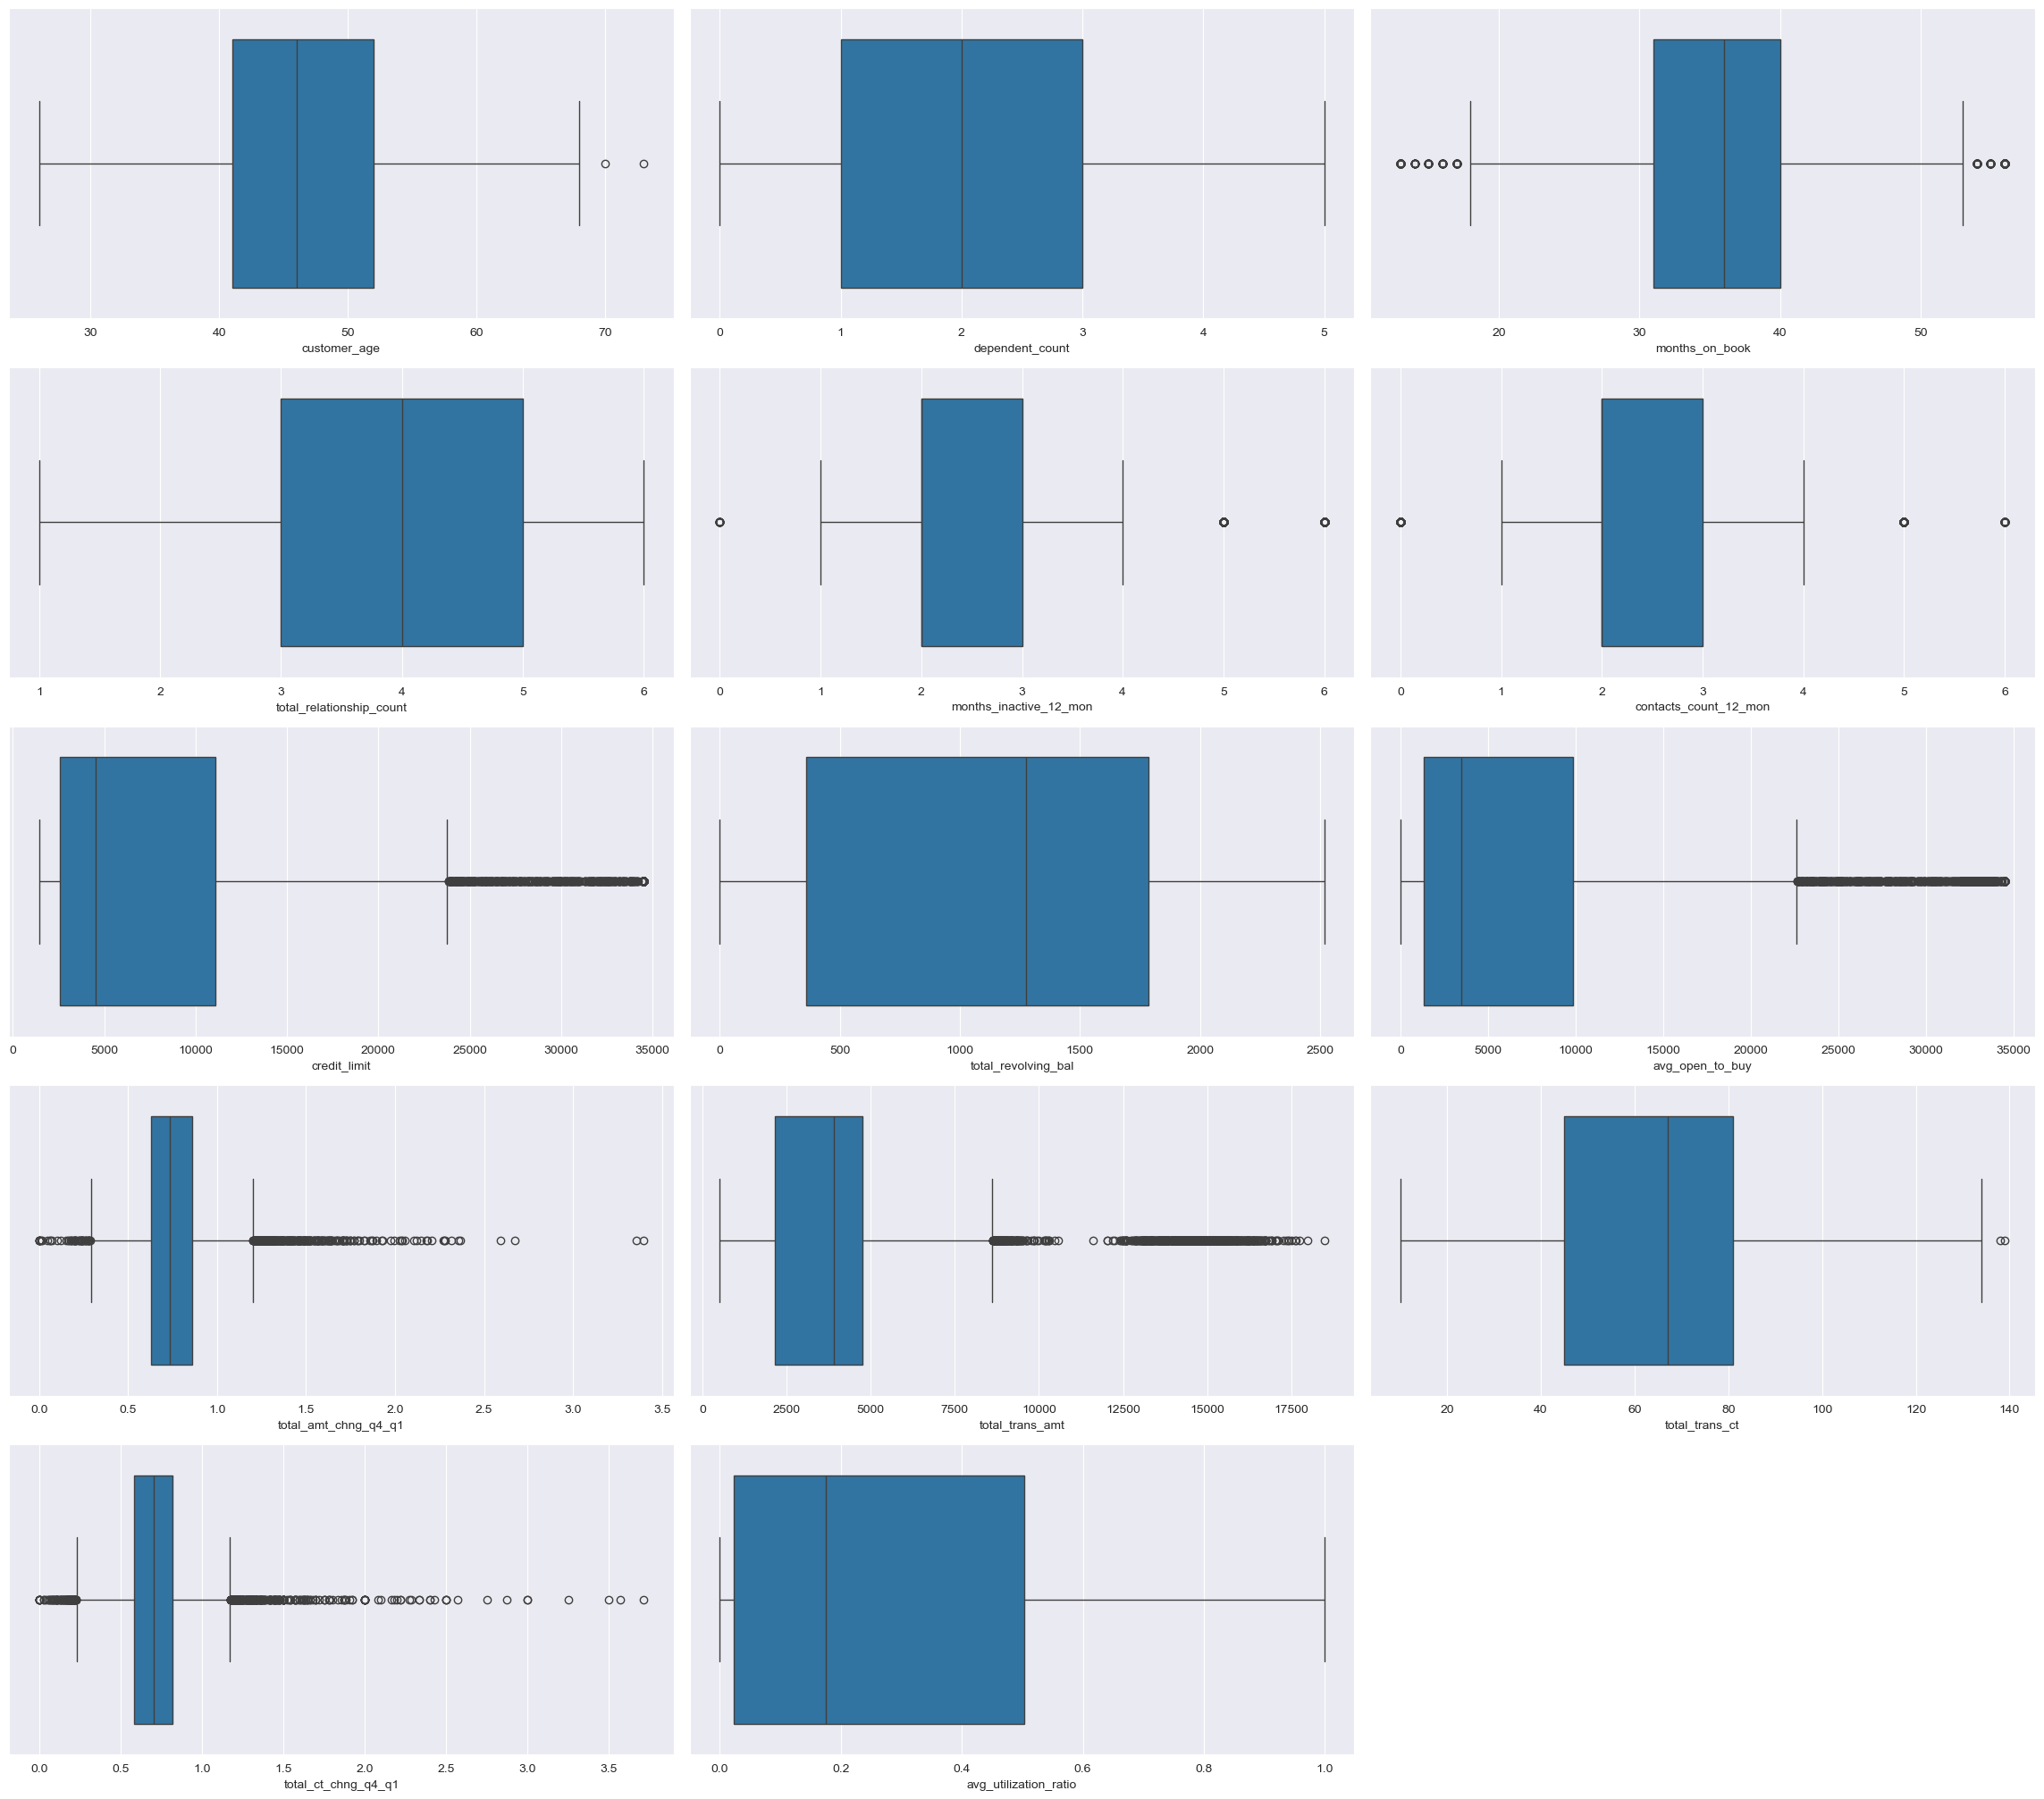

Количество выбросов в customer_age: 2
Количество выбросов в dependent_count: 0
Количество выбросов в months_on_book: 386
Количество выбросов в total_relationship_count: 0
Количество выбросов в months_inactive_12_mon: 331
Количество выбросов в contacts_count_12_mon: 629
Количество выбросов в credit_limit: 984
Количество выбросов в total_revolving_bal: 0
Количество выбросов в avg_open_to_buy: 963
Количество выбросов в total_amt_chng_q4_q1: 396
Количество выбросов в total_trans_amt: 896
Количество выбросов в total_trans_ct: 2
Количество выбросов в total_ct_chng_q4_q1: 394
Количество выбросов в avg_utilization_ratio: 0

Общее количество выбросов во всех столбцах: 4983


In [16]:
# Поработаем с количиственными признаками 
credit_box_plot = credit.copy().drop(columns = 'clientnum')
numerical_features = credit_box_plot.select_dtypes(include=['float', 'int']).columns.tolist()

# Так как у нас немного фичей можно попробовать визуализировать все наши box-plot 
plt.figure(figsize=(23, 4 * len(numerical_features))) 
for i, col in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 3, i + 1)
    sns.boxplot(x=credit_box_plot[col])

plt.tight_layout()
plt.show()


def detect(data, column): # определяем границы Q1 и Q2 и какое количество данных находится за этими границами
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

outlier_counts = {}
for col in numerical_features: 
    outliers = detect(credit_box_plot, col)
    outlier_counts[col] = len(outliers)
    print(f"Количество выбросов в {col}: {len(outliers)}")
    
total_outliers = sum(outlier_counts.values())
print(f"\nОбщее количество выбросов во всех столбцах: {total_outliers}")

In [17]:
# Давайте поиследуем аномалии в интересующих меня фичах
interesting = ['credit_limit', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_ct_chng_q4_q1','total_revolving_bal']

credit[interesting].describe() # credit_limit и avg_open_to_buy слишком различаются средние и медиана

,credit_limit,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_revolving_bal
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,8631.953698,7469.139637,0.759941,4404.086304,0.712222,1162.814061
std,9088.776650,9090.685324,0.219207,3397.129254,0.238086,814.987335
min,1438.300000,3.000000,0.000000,510.000000,0.000000,0.000000
25%,2555.000000,1324.500000,0.631000,2155.500000,0.582000,359.000000
50%,4549.000000,3474.000000,0.736000,3899.000000,0.702000,1276.000000
75%,11067.500000,9859.000000,0.859000,4741.000000,0.818000,1784.000000
max,34516.000000,34516.000000,3.397000,18484.000000,3.714000,2517.000000


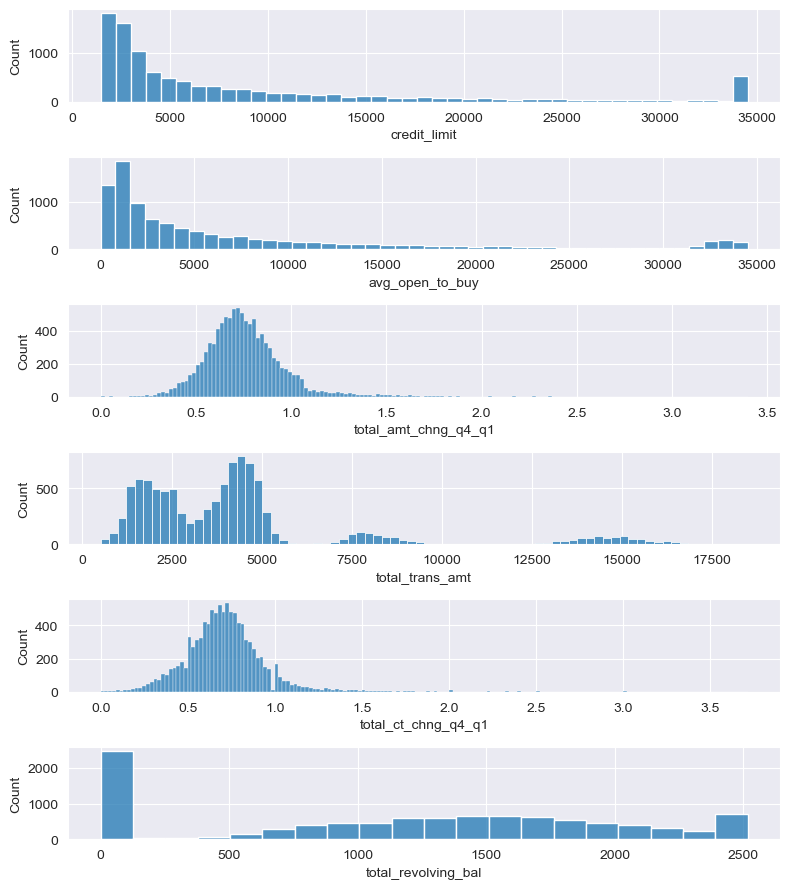

In [18]:
# Построим хистограммы, для исследования распределений

plt.figure(figsize=(8,9))
for i, x in enumerate(interesting):
    plt.subplot(len(interesting), 1, i + 1)
    sns.histplot(credit[x])

plt.tight_layout()
plt.show()

# print(credit['customer_age'].value_counts().tail(5)) # Всё классно
# credit['credit_limit'].value_counts().sort_values(ascending=False)

**В данном наборе данных мы работаем с клиентами банка, в таком случае удалять аномальные значения надо с очень большой аккуратностью.**

Что мы можем сказать о графиках, где мы обнаружили много аномалий:

В кредитном лимите на карте есть довольно большая часть людей с большим кредитным лимитом, в это можно легко поверить, но это может быть возможно заглушкой, надо проверить.

'total_revolving_bal' - Общий оборотный баланс на кредитной карте, хоть и не имеет аномалий, но очень странное распределение, где большинство находится либо в 0, либо на самом максимум в 2500. Надо в этом разобраться по возможности

'total_amt_chng_q4_q1' - Изменение суммы транзакции (Q4 по сравнению с Q1) 
'total_ct_chng_q4_q1' - Изменение количества транзакций (Q4 над Q1) 
Обе эти фичи имеют явное нормально распределенеи их можно дополнительно исследовать на аномалии с помощью z-test

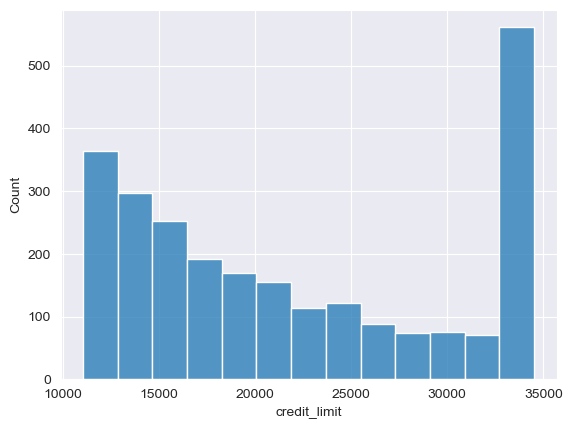

credit_limit
34516.0    508
1438.3     507
Name: count, dtype: int64
Минимальное значение 1438.3
Максимальное значение 34516.0


In [20]:
# Рассмотрим credit_limit
Q3 = credit['credit_limit'].quantile(0.75)

credit_limit_more_Q3 = credit['credit_limit'][credit['credit_limit'] > Q3]
sns.histplot(credit_limit_more_Q3)
plt.show()

print(credit['credit_limit'].value_counts().head(2))
print(f'Минимальное значение {credit['credit_limit'].min()}')
print(f'Максимальное значение {credit['credit_limit'].max()}')

Такие выраженные участки в начале и в конце, из-за того что скорей всего это минимум по кредитному лимиту и максимум соответственно, так что убирать это не нужно, но при работы с этими данными это стоит учитывать

In [19]:
credit['total_revolving_bal'].value_counts().head(2) 

total_revolving_bal
0       2470
2517     508
Name: count, dtype: int64

Кстати, если подумать, у нас целевая переменная это активен ли клиент или нет, а в total_revolving_bal как раз показывает оборот клиента, и у нас много значений с 0, хм давайте проверим гипотезу, то что если у нас оборот равен 0, то клиент не активен

In [22]:
test = credit[['attrition_flag', 'total_revolving_bal']][credit['total_revolving_bal'] == 0]
test = test.groupby('attrition_flag', as_index = False).agg({'total_revolving_bal': 'count'})
print(credit['attrition_flag'].value_counts())
test

attrition_flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64


,attrition_flag,total_revolving_bal
0,Attrited Customer,893
1,Existing Customer,1577


Итог, только по одной переменной мы нашли больше половины людей которые неактивничали на карте.

## Z score

163


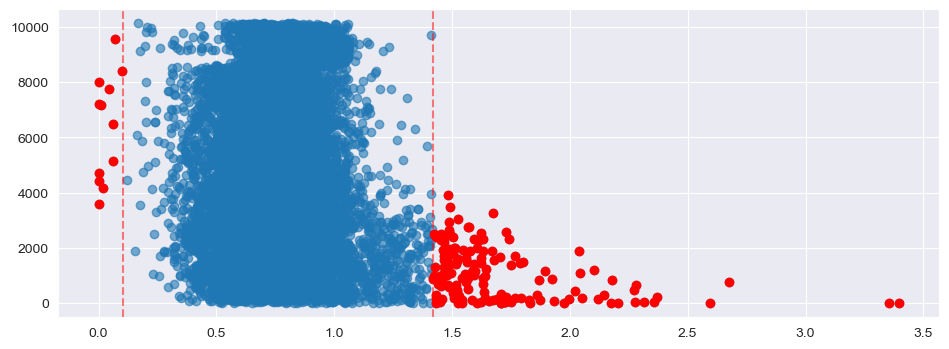

In [23]:
z_scores = scipy.stats.zscore(credit['total_amt_chng_q4_q1'])
anomalies = credit['total_amt_chng_q4_q1'][abs(z_scores) > 3]
print(anomalies.count())
plt.figure(figsize = (25,4))
plt.subplot(1, 2, 1)
plt.scatter( credit['total_amt_chng_q4_q1'], credit['total_amt_chng_q4_q1'].index, alpha=0.6, label='Обычные данные')
plt.scatter(anomalies,anomalies.index, color='red', label='Аномалии (|z| > 3)')
plt.axvline(x=credit['total_amt_chng_q4_q1'].mean() + 3*credit['total_amt_chng_q4_q1'].std(), color='r', linestyle='--', alpha=0.5)
plt.axvline(x=credit['total_amt_chng_q4_q1'].mean() - 3*credit['total_amt_chng_q4_q1'].std(), color='r', linestyle='--', alpha=0.5)
plt.show()

Таким способом мы нашли 163 аномалии, а box plot в сравнение обнаружил тут 396 аномалий, что примерно равняется в отклонение 2.1 сигмы

В данной переменной - изменение суммы транзакций я бы не стал ничего удалять без предварительной договорённости с владельцем данных, хотя для некоторых алгоритмов МО такие аномальные значения могут быть критическими, но мы проводим обычный анализ, поэтому ничего удалять не станем

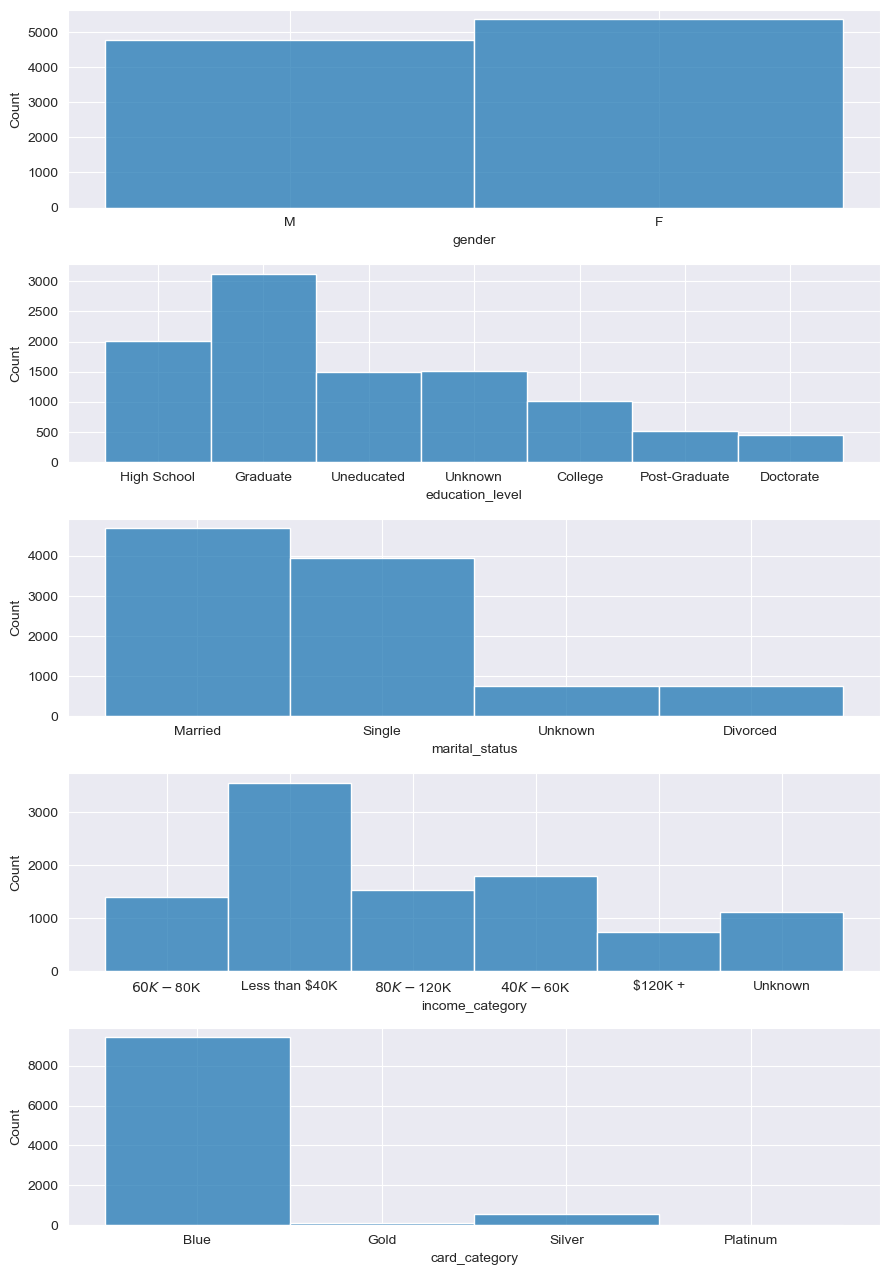

In [24]:
# Посмотрим на категориальные признаки

categorical_features = credit.select_dtypes(include = ['object']).columns.to_list() 
plt.figure(figsize = (9, 15))
for i, column in enumerate(categorical_features[1:]):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.histplot(credit[column])
    
plt.tight_layout()
plt.show()


Единственное что тут можно назвать аномалией это категория карты, но это обусловлено малым количеством людей, которые обладают картами platimun/gold не более

## Isolation Forest

In [25]:
credit_isolation_forest = credit.copy().drop(columns = 'clientnum')

# Разделяем на категориальные и остальные для правильной обработки
categorical_features = credit_isolation_forest.select_dtypes(include = ['object']).columns.to_list()
numerical_features = credit_isolation_forest.select_dtypes(exclude=['object']).columns.to_list()

label_encoders = {}
for col in categorical_features: # энкодинг категориальных признаков
    label_encoders[col] = LabelEncoder()
    credit_isolation_forest[col] = label_encoders[col].fit_transform(credit_isolation_forest[col]) 

scaler = StandardScaler()
iso_scaled = scaler.fit_transform(credit_isolation_forest[numerical_features + categorical_features])

iso_forest = IsolationForest(n_estimators=100, contamination='auto')
iso_forest.fit(iso_scaled)

credit_isolation_forest['anomaly'] = iso_forest.predict(iso_scaled)
credit_isolation_forest['anomaly_score'] = iso_forest.decision_function(iso_scaled)

print(f' Средний score: {credit_isolation_forest['anomaly_score'].mean()}')
print(f' Количество аномалий найденных Isolation_forest: {np.where(credit_isolation_forest['anomaly'] == 1, 0, 1).sum()}') # -1 это аномалия

 Средний score: 0.023851255886354707
 Количество аномалий найденных Isolation_forest: 2498


Визуализировать столько параметров будет сложновато

Воспользуемся PCA, чтобы уменьшить размерность для возможности визуализировать итог работы Isolation Forest

In [26]:
credit_copy_2 = credit.copy()

X = credit_copy_2.drop(columns = ['clientnum','attrition_flag']).select_dtypes(exclude = ['object'])
feature_names = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

feature_importances = np.sum(pca.components_**2, axis=0)
#  Нормализуем, чтобы значимость была от 0 до 1
feature_importances /= np.sum(feature_importances)


importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

print("Суммарная объясненная дисперсия:", np.sum(pca.explained_variance_ratio_)) # Маловато ну что поделаешь
importance_df = importance_df.reset_index(drop = True).iloc[0:2]
importance_df = importance_df['Feature'].to_list()

Суммарная объясненная дисперсия: 0.3295146494387614


 Средний score: 0.025323553931716095
 Количество аномалий найденных Isolation_forest: 133, всего значений 500


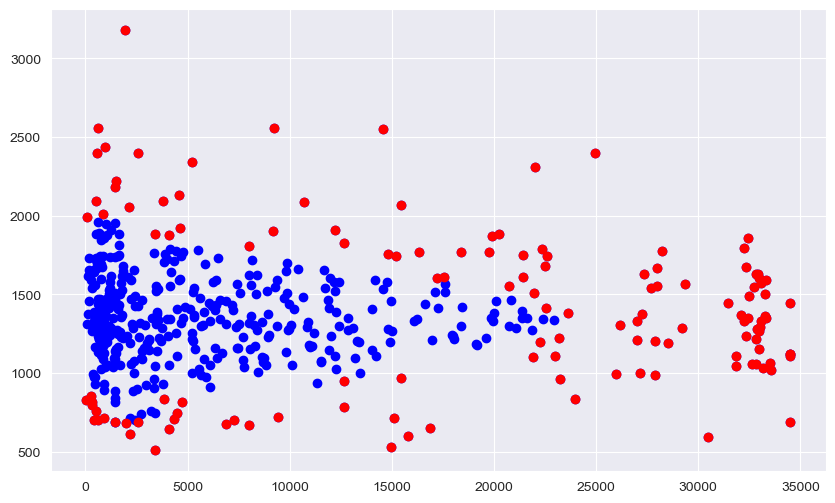

In [27]:
forest_PCA = credit[importance_df].head(500) # Возьмём данных поменьше для наглядности

scaler = StandardScaler()
iso_scaled_PCA = scaler.fit_transform(forest_PCA)

model_iso_forest_PCA = IsolationForest(n_estimators=100, contamination='auto')
model_iso_forest_PCA.fit(iso_scaled_PCA)

forest_PCA['anomaly'] = model_iso_forest_PCA.predict(iso_scaled_PCA)
forest_PCA['anomaly_score'] = model_iso_forest_PCA.decision_function(iso_scaled_PCA)

print(f' Средний score: {forest_PCA['anomaly_score'].mean()}')
print(fr' Количество аномалий найденных Isolation_forest: {np.where(forest_PCA['anomaly'] == 1, 0, 1).sum()}, всего значений {len(forest_PCA)}')

plt.figure(figsize = (10,6))
plt.scatter(forest_PCA['avg_open_to_buy'], forest_PCA['total_trans_amt'], c = 'blue')
plt.scatter(forest_PCA['avg_open_to_buy'][forest_PCA['anomaly'] == -1], forest_PCA['total_trans_amt'][forest_PCA['anomaly'] == -1], c = 'red')
plt.show()


# Кластаризация
В этом датасете есть целевая переменная, указанная автором данных, но моя цель посравнивать алгоритмы Кластаризации на реальных данных, так что давайте попробуем вместе с сравнением основных алгоритмов, также постараться предсказывать и целевую метку (почему бы и нет)

In [28]:
claster_df = credit.copy()
index = claster_df['clientnum']

X_train = claster_df.drop(columns = ['clientnum','attrition_flag'])
y_train = claster_df['attrition_flag'].replace({'Attrited Customer':1,'Existing Customer':0})

C:\Users\sekin\AppData\Local\Temp\ipykernel_20108\606244481.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = claster_df['attrition_flag'].replace({'Attrited Customer':1,'Existing Customer':0})


In [29]:
# Находим самые важные фичи для нашей целевой переменной (чтобы в теории смогли предсказать нашу целевую переменную, 
# которые будем использовать в дальнейшем для анализа
X = credit.drop(columns=['clientnum', 'attrition_flag'])
y = credit['attrition_flag']

numerical_features = X.select_dtypes(include=['float64', 'int64'])
categorical_features = X.select_dtypes(include=['object'])

# бинн
discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')
numerical_discretized = discretizer.fit_transform(numerical_features)
numerical_discretized_df = pd.DataFrame(numerical_discretized, columns=numerical_features.columns)

categorical_encoded = pd.get_dummies(categorical_features, dtype=int, drop_first = True)

X_processed = pd.concat([numerical_discretized_df, categorical_encoded], axis=1)

bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X_processed, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_processed.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
feature = featureScores.nlargest(5, 'Score')
feature['Score'] = feature['Score'].round(0)
main_feature = feature.sort_values('Score', ascending=False)['Specs'].to_list()
feature

C:\Users\sekin\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,Specs,Score
7,total_revolving_bal,868.0
11,total_trans_ct,809.0
10,total_trans_amt,630.0
13,avg_utilization_ratio,407.0
12,total_ct_chng_q4_q1,346.0


Самым важной фичой для нашей целевой переменной оказался total_revolving_bal, тоесть мы правильно определили выше, что от этого параметра многое зависит.

## K-means

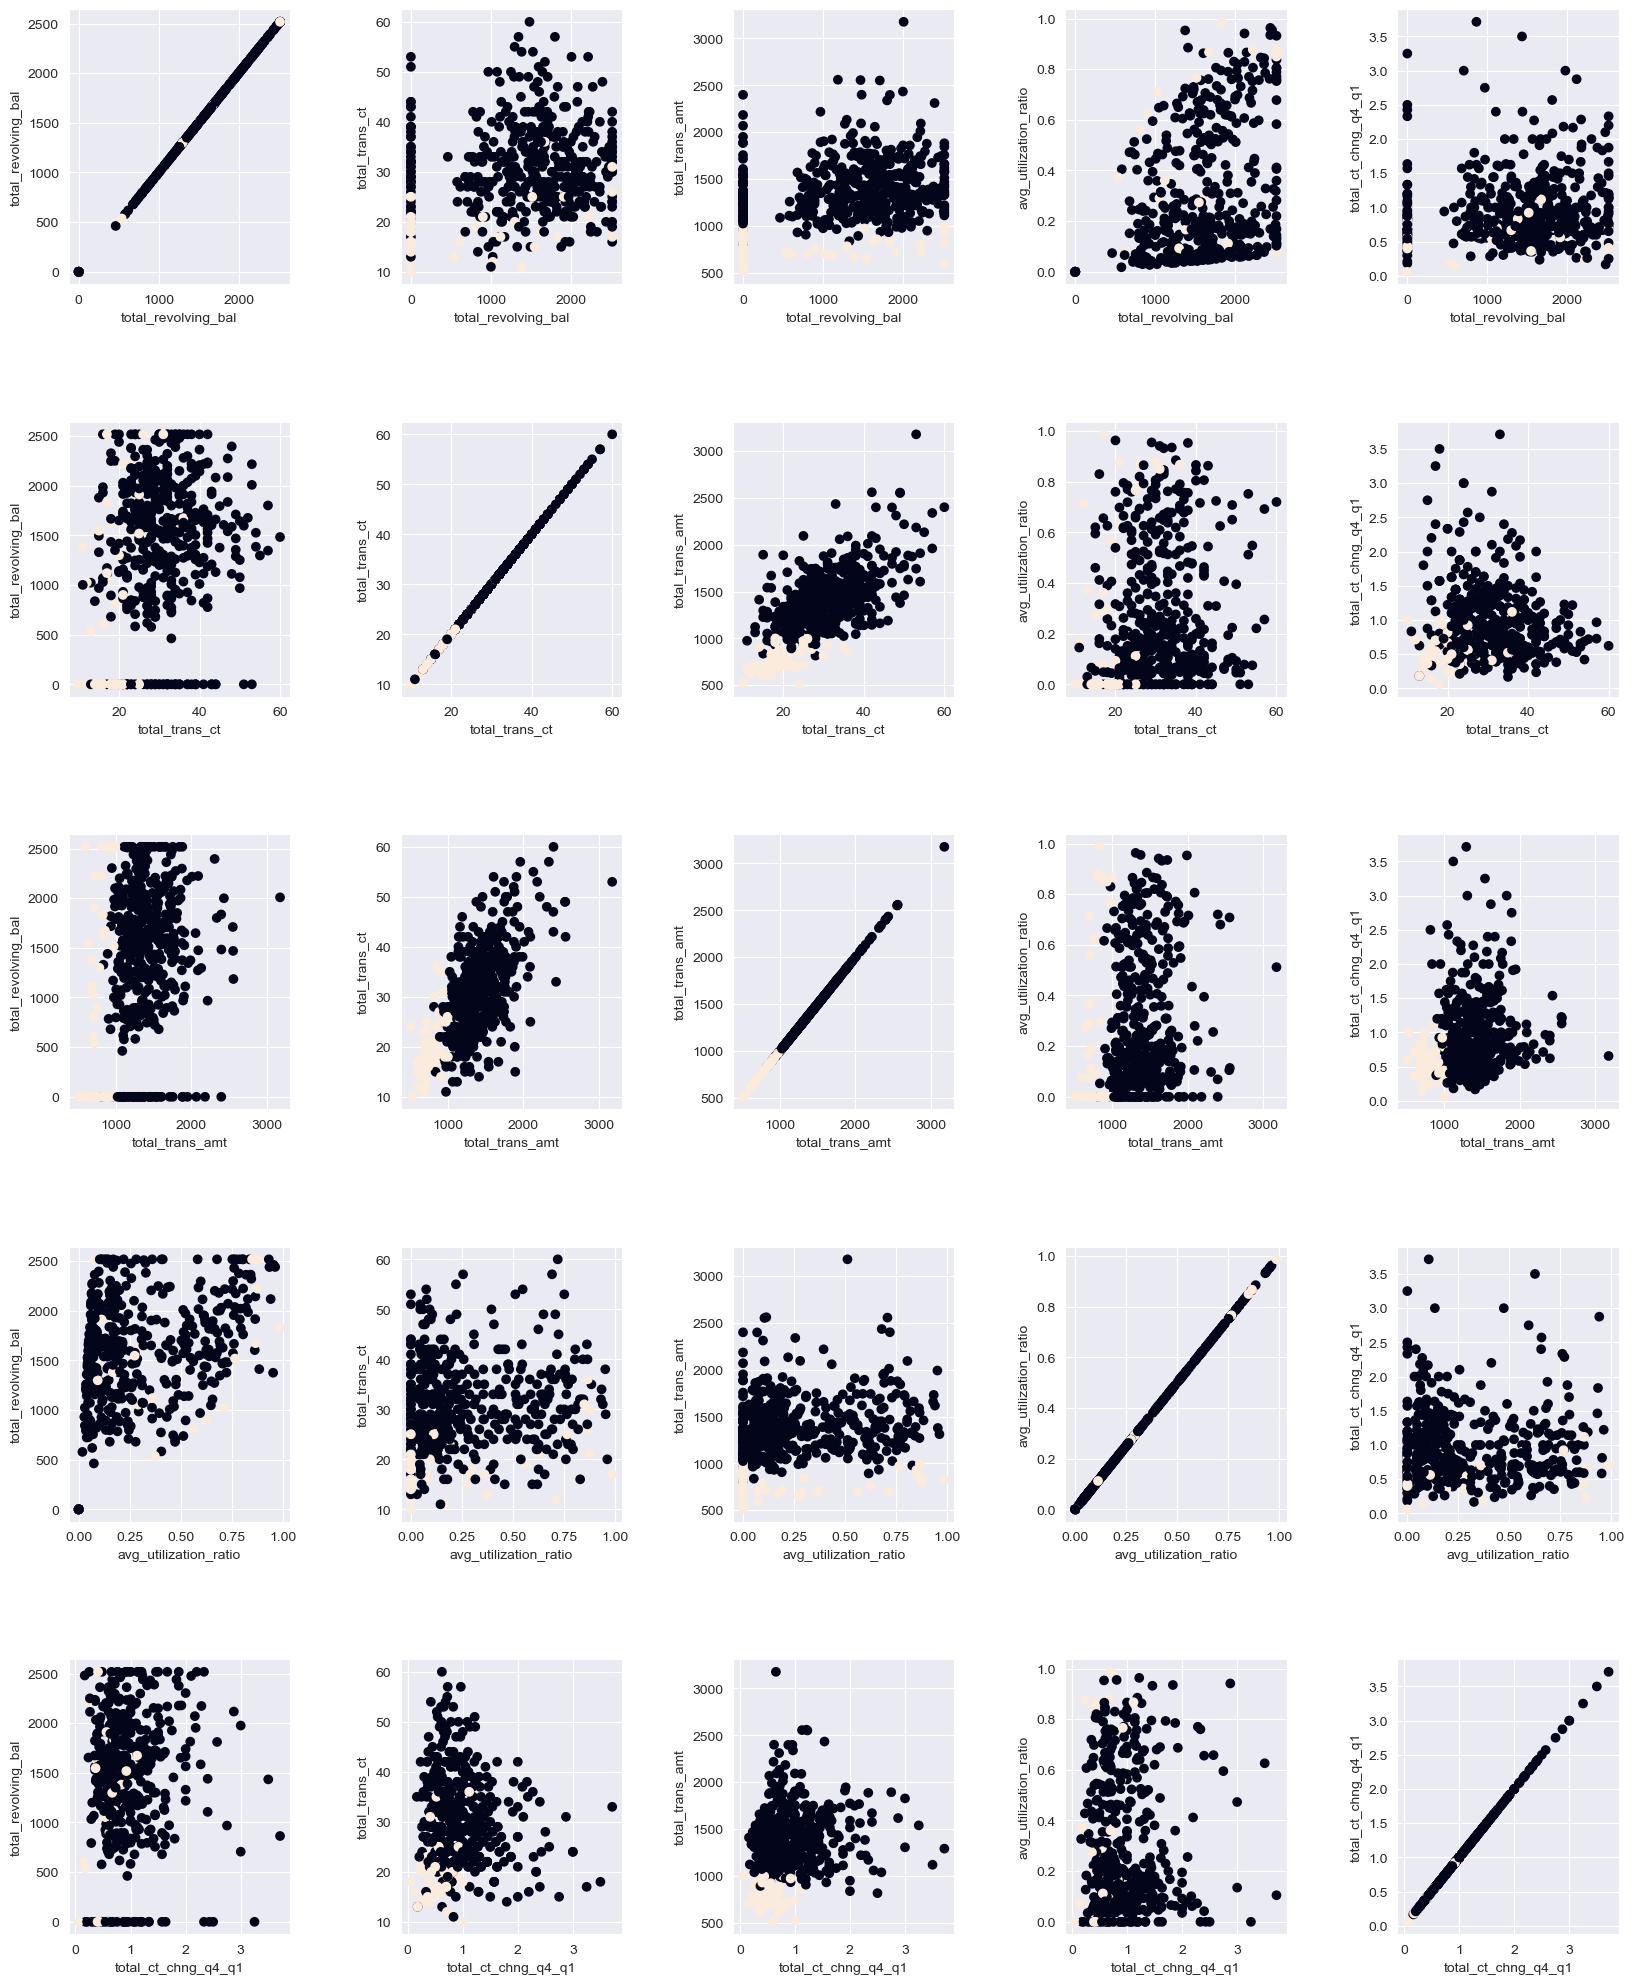

In [30]:
# Так как мы себе поставили задачу приблизиться к обычной классификации, возьмём только главные фичи для нашей целевой переменной, чтобы проверить,
# как они распределены
plt.figure(1 , figsize = (20 , 25))
n = 0 
for x in main_feature:
    for y in main_feature:
        n += 1
        plt.subplot(5 , 5 , n)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        plt.scatter(x = x , y = y , data = X_train[main_feature].head(500), c = y_train.head(500))
        plt.ylabel(y)
        plt.xlabel(x)
plt.show()

Тут зависимость не совсем под кластаризацию, если опираться на целевую переменную. Но всё-же с несколькими переменными можно поработать. 

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

# фичи которая показалась мне интересна
X_scaled = X_train[['total_trans_amt', 'total_revolving_bal']]
# Со скалером, результаты алгоритма становились хуже, поэтому в kmeans без него

k_means = KMeans(n_clusters = 2, random_state = 45) # Мы знаем сколько нужно кластеров поэтому без локтя
k_means = k_means.fit(X_scaled)
clusters = k_means.predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Среднее значение силуэта: {silhouette_avg :.2f}")
print(f" Оценка Дэвиса: {davies_bouldin_score(X_scaled, clusters)}")
print(f" Точность: {accuracy_score(y_train, clusters)}")

Среднее значение силуэта: 0.76
 Оценка Дэвиса: 0.330026121809036
 Точность: 0.23165794410980547


С точки зрения силуэта неплохо, но обычная метрика для классфикации не сработает, так как Kmeans делит данные как ему вздумается, у него нет учителя, но я поигрался с random_state и он смог выдать 0.76, что я считаю не очень и плохо, для всего-то двух переменных, но всё-же precision здесь нецелеобразно использовать, но почему бы и нет

Text(0.5, 0, 'Реальное разделение')

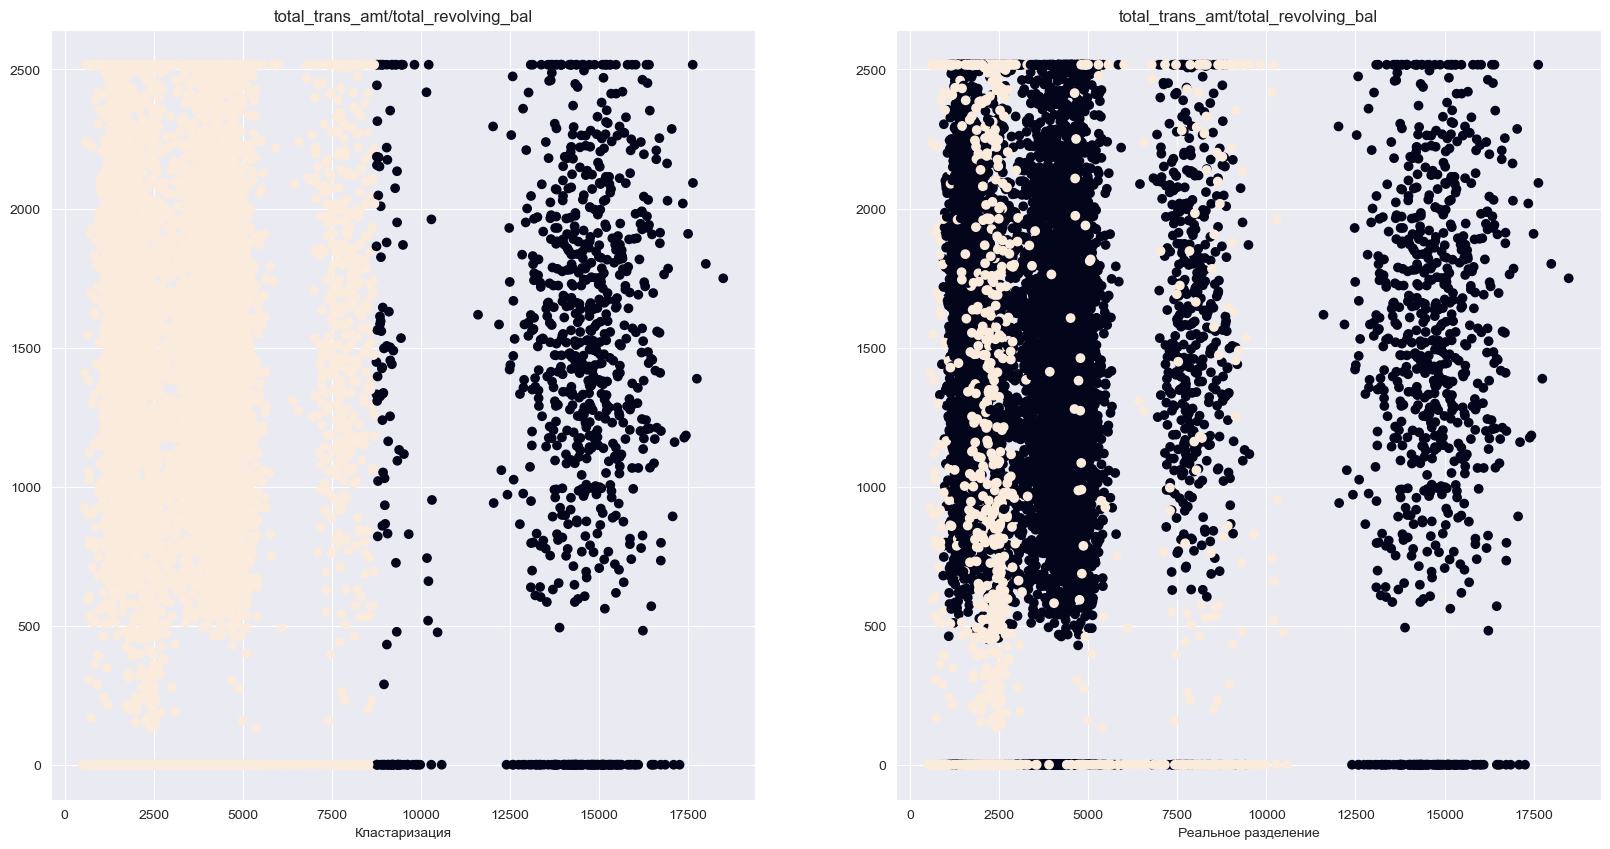

In [32]:
plt.figure(1, figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.scatter(X_train['total_trans_amt'], X_train['total_revolving_bal'], c=clusters) 
plt.title('total_trans_amt/total_revolving_bal')
plt.xlabel('Кластаризация')

plt.subplot(1, 2, 2)
plt.scatter(X_train['total_trans_amt'], X_train['total_revolving_bal'], c=y_train) 
plt.title('total_trans_amt/total_revolving_bal')
plt.xlabel('Реальное разделение')


Эти фичи буду использовать и для других алгоритмов, для сравнения

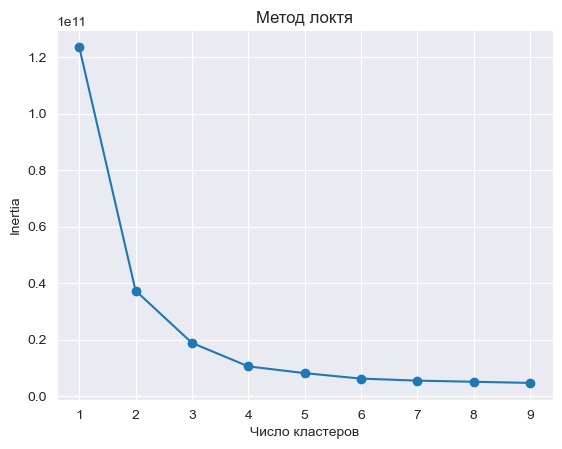

Среднее значение силуэта: 0.54
 Оценка Дэвиса: 0.5819217142437124


In [33]:
# Попробуем выставить параметр оснвоываясь на методе локтя

X_scaled = X_train[['total_trans_amt', 'total_revolving_bal']]

k_means = KMeans(n_clusters = 4, random_state = 45)
k_means = k_means.fit(X_scaled)
clusters = k_means.predict(X_scaled)

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя')
plt.show()

silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Среднее значение силуэта: {silhouette_avg:.2f}")
print(f" Оценка Дэвиса: {davies_bouldin_score(X_scaled, clusters)}")

Результат ухудшился

Text(0.5, 0, 'Кластаризация')

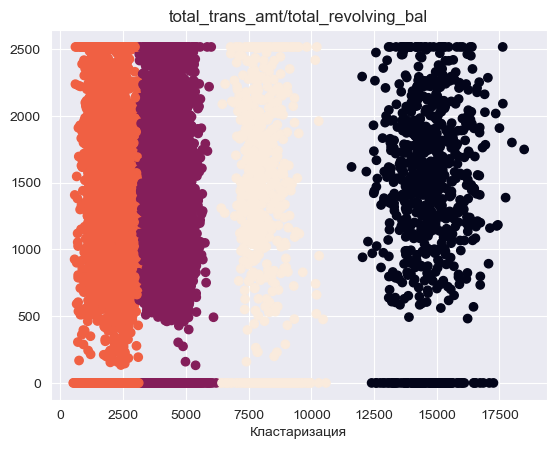

In [35]:
plt.scatter(X_train['total_trans_amt'], X_train['total_revolving_bal'], c=clusters) 
plt.title('total_trans_amt/total_revolving_bal')
plt.xlabel('Кластаризация')

In [36]:
## Поработаем с самыми главными фичами, которые нашли выше 
X_scaled = X_train[main_feature]

k_means = KMeans(n_clusters = 2)
k_means = k_means.fit(X_scaled)
clusters = k_means.predict(X_scaled)
    
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Среднее значение силуэта: {silhouette_avg:.2f}")
print(f"Оценка Дэвиса: {davies_bouldin_score(X_scaled, clusters)}")

Среднее значение силуэта: 0.76
Оценка Дэвиса: 0.33004342787818736


In [37]:
## Поработаем со всеми фичам

X_scaled = pd.get_dummies(X_train, dtype = int)
k_means = KMeans(n_clusters = 2)
k_means = k_means.fit(X_scaled)
clusters = k_means.predict(X_scaled)
    
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Среднее значение силуэта: {silhouette_avg:.2f}")
print(f"Оценка Дэвиса: {davies_bouldin_score(X_scaled, clusters)}")

Среднее значение силуэта: 0.71
Оценка Дэвиса: 0.5109776141363017


# DBSCAN

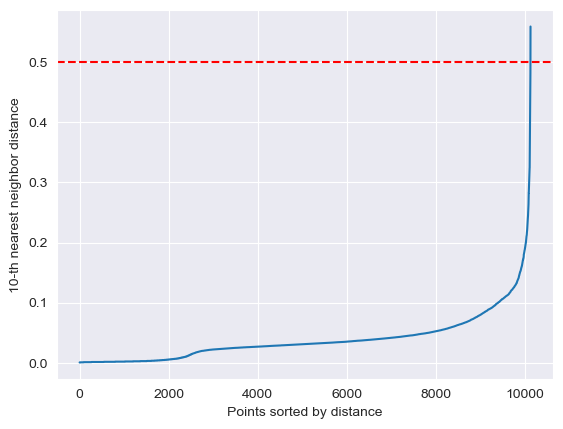

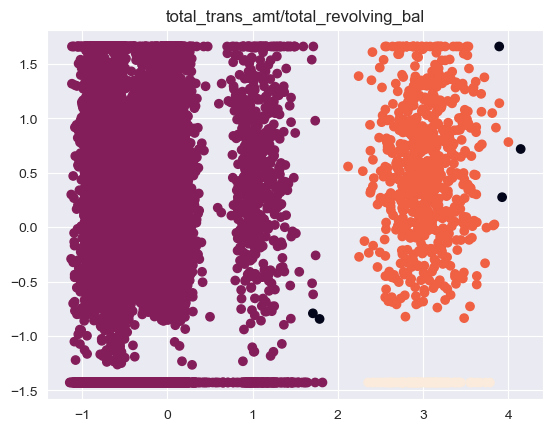

Среднее значение силуэта для двух фич: 0.555351476882211
 Оценка Дэвиса для двух фич: 3.4793286755059327
Среднее значение силуэта для основных фич: -0.3858050241745563
 Оценка Дэвиса для основных фич: 1.9042868308106924


In [38]:
scaler = StandardScaler()
X_scaled_2_feature = scaler.fit_transform(X_train[['total_trans_amt', 'total_revolving_bal']])

min_samples = 10  # 2 фичи

# Вычисляем eps по графику
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled_2_feature)
distances, _ = nn.kneighbors(X_scaled_2_feature)
k_distances =  np.sort(distances[:, -1])

plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-th nearest neighbor distance")
plt.axhline(y=0.5, color='r', linestyle='--')  # Примерное значение eps
plt.show()


DBSCAN_2_f = DBSCAN(eps = 0.3, min_samples=10)
clusters = DBSCAN_2_f.fit_predict(X_scaled_2_feature)

plt.scatter(X_scaled_2_feature[:, 0], X_scaled_2_feature[:, 1], c=clusters) 
plt.title('total_trans_amt/total_revolving_bal')
plt.show()

print(f"Среднее значение силуэта для двух фич: {silhouette_score(X_scaled_2_feature, clusters)}")
print(f" Оценка Дэвиса для двух фич: {davies_bouldin_score(X_scaled_2_feature, clusters)}")

X_scaled_main_feature = scaler.fit_transform(X_train[main_feature])
DBSCAN_main = DBSCAN(eps = 0.3, min_samples=10)
clusters = DBSCAN_main.fit_predict(X_scaled_main_feature)

print(f"Среднее значение силуэта для основных фич: {silhouette_score(X_scaled_main_feature, clusters)}")
print(f" Оценка Дэвиса для основных фич: {davies_bouldin_score(X_scaled_main_feature, clusters)}")


## Иерархическая кластаризация

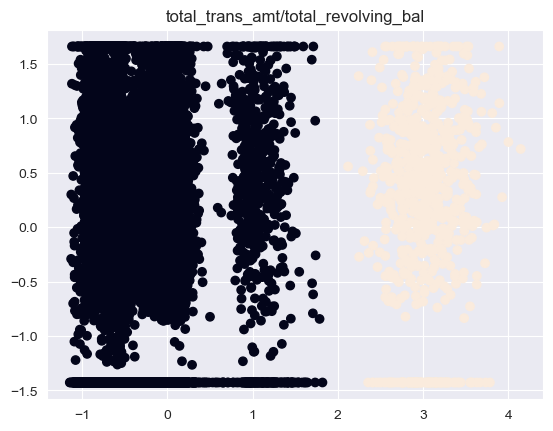

Среднее значение силуэта для двух фич: 0.598707154318377
 Оценка Дэвиса для двух фич: 0.5537211211365045


In [39]:
scaler = StandardScaler()
X_scaled_2_feature = scaler.fit_transform(X_train[['total_trans_amt', 'total_revolving_bal']])

Agg_clusters = AgglomerativeClustering(n_clusters=2)
clusters = Agg_clusters.fit_predict(X_scaled_2_feature)

plt.scatter(X_scaled_2_feature[:, 0], X_scaled_2_feature[:, 1], c=clusters) 
plt.title('total_trans_amt/total_revolving_bal')
plt.show()

print(f"Среднее значение силуэта для двух фич: {silhouette_score(X_scaled_2_feature, clusters)}")
print(f" Оценка Дэвиса для двух фич: {davies_bouldin_score(X_scaled_2_feature, clusters)}")

# Сделаем сравнение алгоритмов

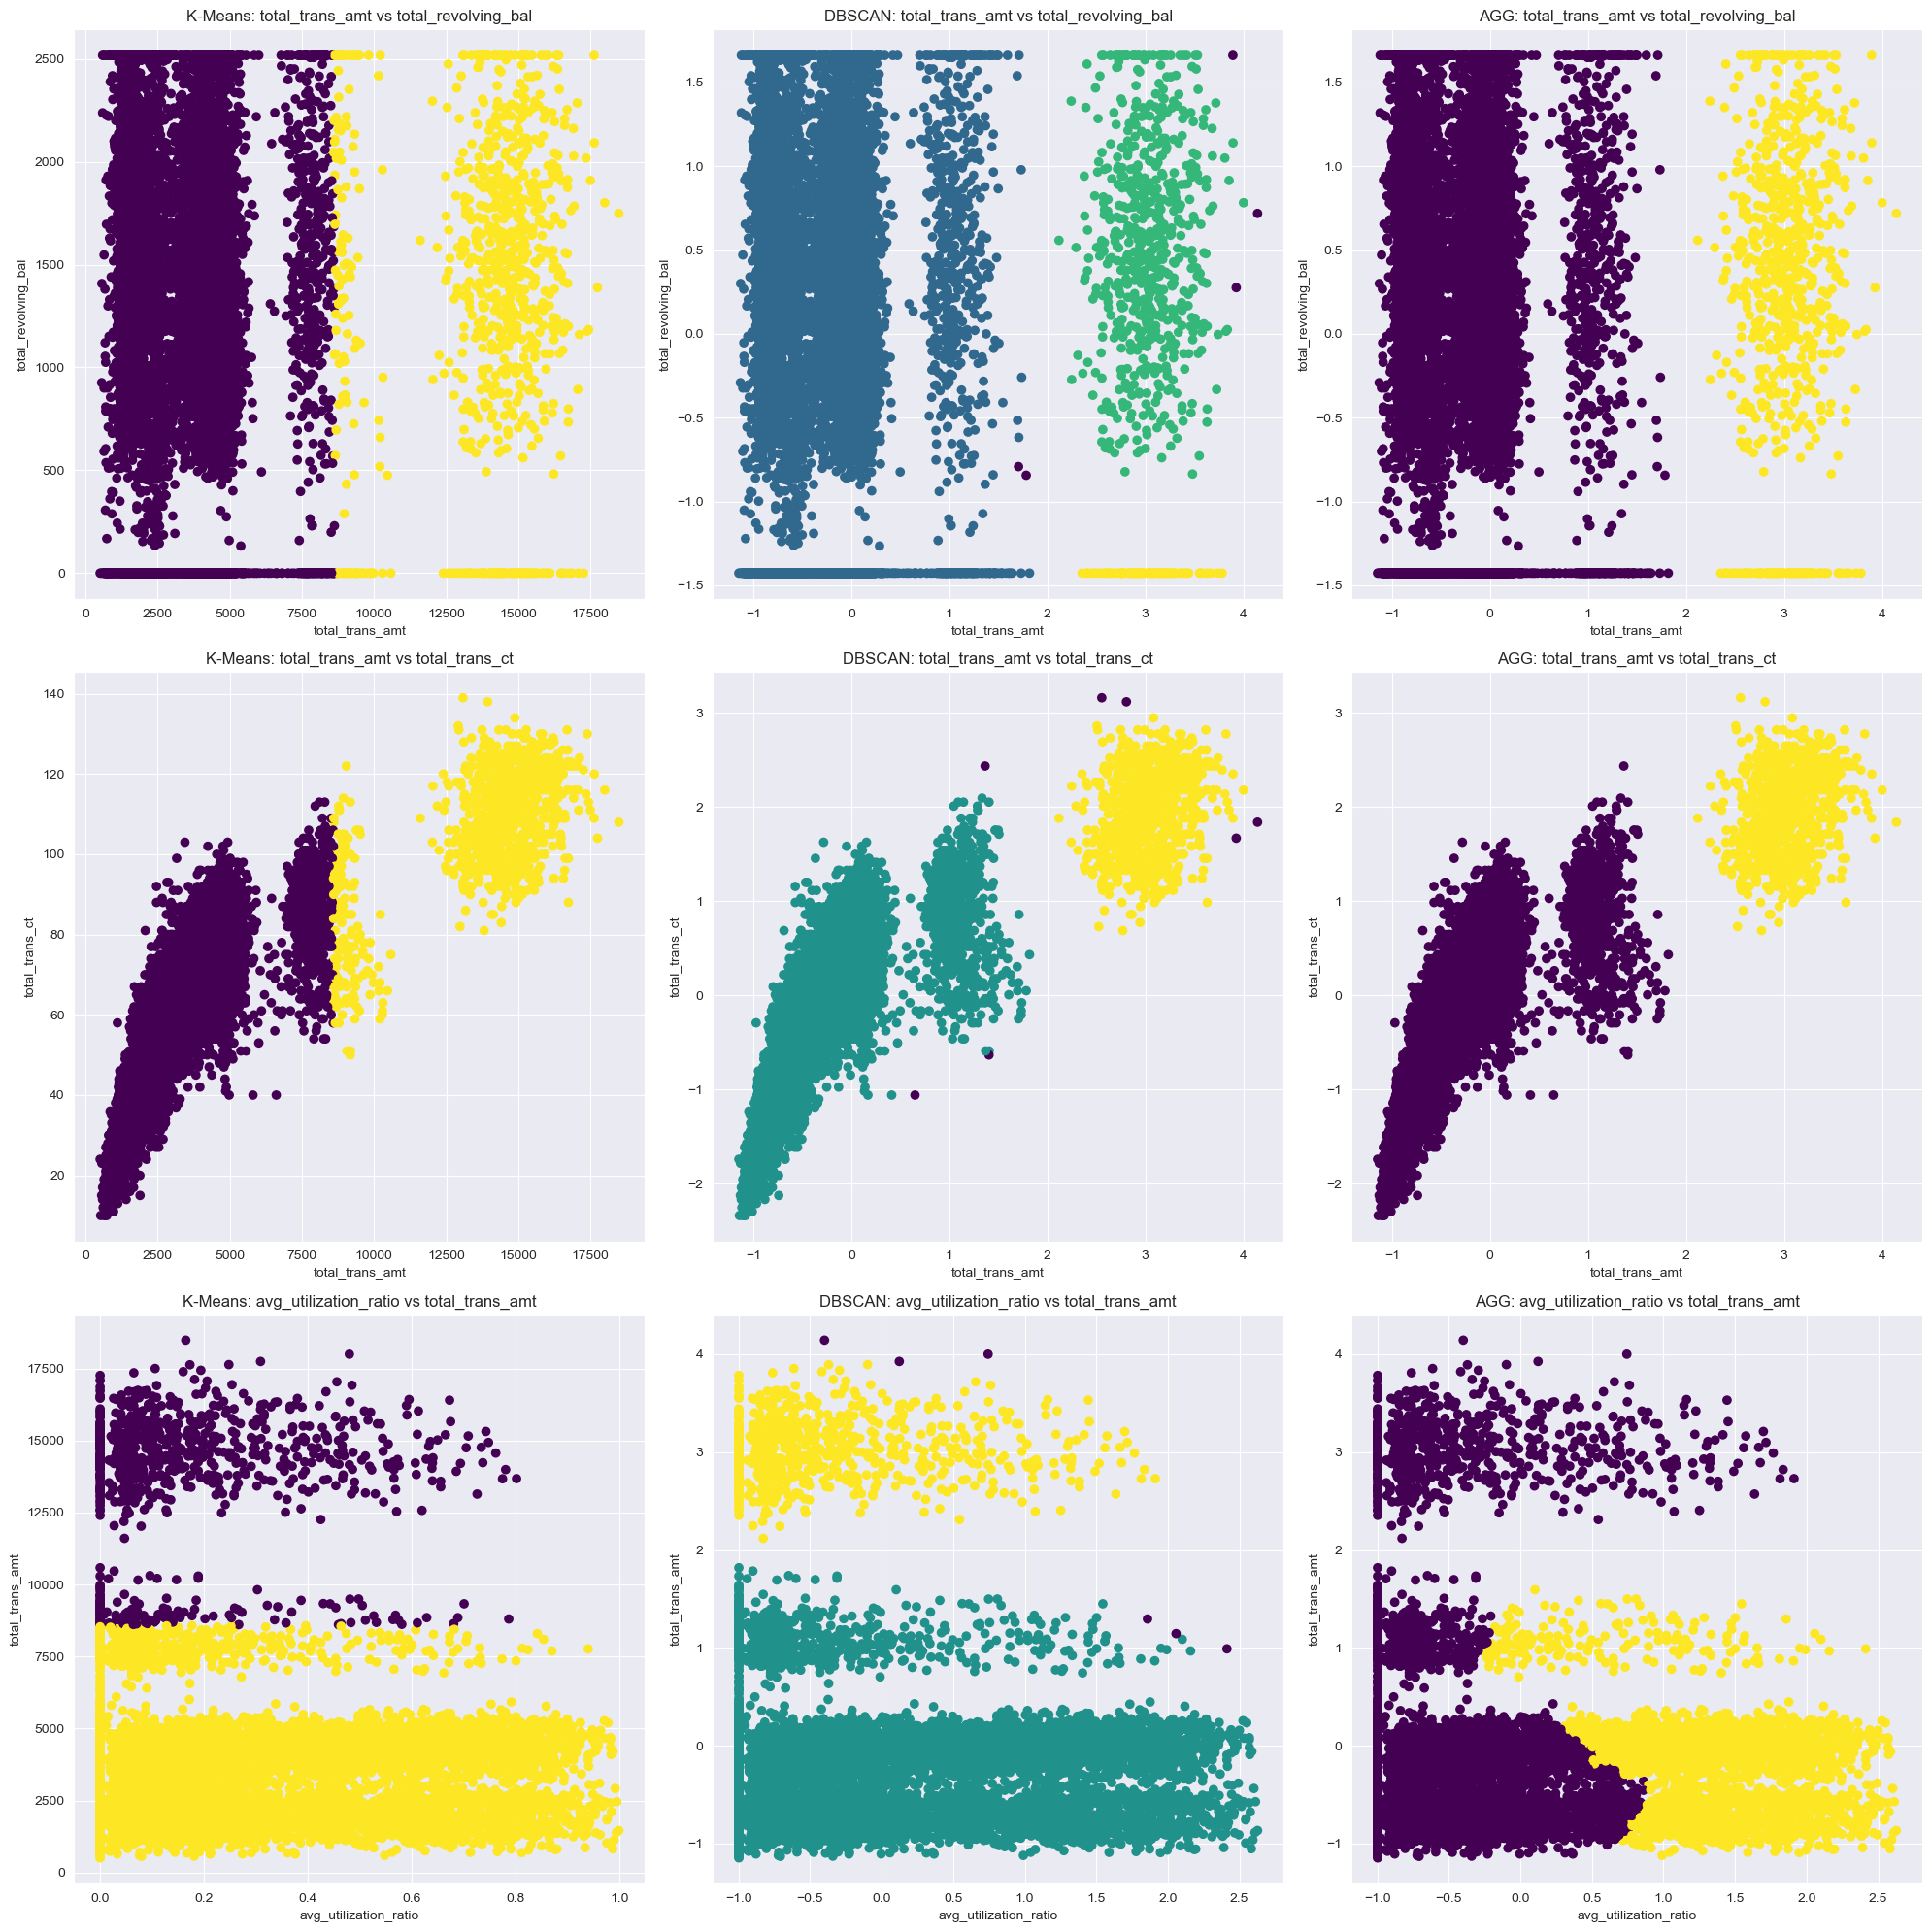

In [42]:
plt.figure(1 , figsize = (20 , 20))
scaler = StandardScaler()

k_means = KMeans(n_clusters = 2) 
dbscan = DBSCAN(eps = 0.3, min_samples=10)
Agg_clusters = AgglomerativeClustering(n_clusters=2)
n = 0

for x_y in [['total_trans_amt','total_revolving_bal'], ['total_trans_amt', 'total_trans_ct'], ['avg_utilization_ratio' ,'total_trans_amt']]:
    X_scaled = scaler.fit_transform(X_train[x_y])
    
    clusters_kmeans = k_means.fit_predict(X_train[x_y])
    plt.subplot(3,3, n+1)
    plt.scatter(x_y[0], x_y[1], data = X_train, c=clusters_kmeans, cmap='viridis')
    plt.xlabel(x_y[0])
    plt.ylabel(x_y[1])
    plt.title(f'K-Means: {x_y[0]} vs {x_y[1]}')

    clusters_dbscan = dbscan.fit_predict(X_scaled)
    plt.subplot(3,3, n+2)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_dbscan, cmap='viridis')
    plt.xlabel(x_y[0])
    plt.ylabel(x_y[1])
    plt.title(f'DBSCAN: {x_y[0]} vs {x_y[1]}')

    clusters_agg = Agg_clusters.fit_predict(X_scaled)
    plt.subplot(3,3, n+3)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_agg, cmap='viridis') 
    plt.xlabel(x_y[0])
    plt.ylabel(x_y[1])
    plt.title(f'AGG: {x_y[0]} vs {x_y[1]}')

    n += 3
    
plt.tight_layout()
plt.show()